In [1]:
import geopandas as gpd
import ipaddress
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio import plot, CRS
import rasterio.warp
import rasterio.features
import shapely
import shapely.geometry
import shapely.wkt
import yaml
import time
from tqdm import tqdm
import os
from pathlib import Path

from datetime import date, datetime, timedelta, timezone
from shapely import Point, Polygon, MultiPolygon, GeometryCollection, Geometry
from typing import Tuple

from aimlsse_api.client import GroundDataClient, SatelliteDataClient
from aimlsse_api.data import *

Make sure that the file `login.yml` exists. If not, create a new one and store your credentials for the [Copernicus OpenAPI Hub](https://scihub.copernicus.eu/dhus/#/home) in the following form:
```
username: <copernicus-username>
password: <copernicus-password>
```
The file is excluded from git to make sure that credentials are kept private.

In [2]:
login_config = yaml.safe_load(open('login.yml'))
username = login_config['username']
password = login_config['password']
copernicus_login = Credentials(username, password)

In [3]:
target_state = 'California'

In [4]:
data_dir = 'data'
target_dir = os.path.join(data_dir, 'queries', target_state)
features_dir = os.path.join(target_dir, 'features')
preprocessing_dir = os.path.join(target_dir, 'preprocessing')
for dir in [data_dir, target_dir, features_dir, preprocessing_dir]:
    os.makedirs(dir, exist_ok=True)
server_ip = '141.52.225.23'

In [5]:
datetime_from = datetime(2022, 8, 1, tzinfo=timezone.utc)
datetime_to = datetime(2023, 2, 1, tzinfo=timezone.utc)
assert datetime_to.date() > datetime_from.date(), f'Dates must be strictly ordered + \
    \nfrom:\t{datetime_from.date()}\nto:\t{datetime_to.date()}'

In [6]:
station_radius_of_influence = 8000.0 # meters

In [7]:
usa_states: gpd.GeoDataFrame = gpd.read_file('input/us_states_5m.geojson')
usa_states.set_index('NAME', inplace=True)

<class 'shapely.geometry.multipolygon.MultiPolygon'>


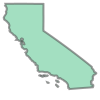

In [8]:
area_of_interest: MultiPolygon = usa_states.loc[target_state].geometry
print(type(area_of_interest))
area_of_interest

In [9]:
def plot_area_of_interest(ax:plt.Axes, color:str):
    gpd.GeoSeries(usa_states.loc[target_state].geometry.buffer(0).boundary).plot(ax=ax, facecolor=color, alpha=1.0, linewidth=0.1, zorder=1)

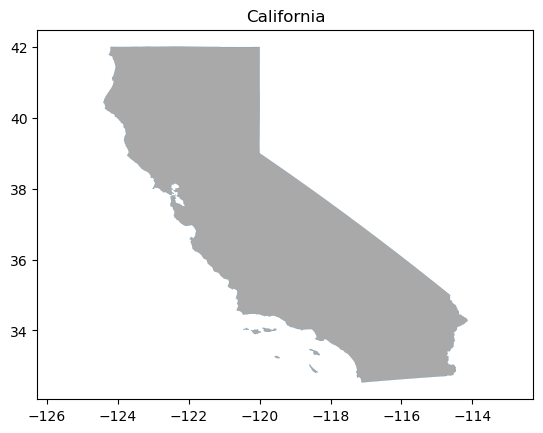

In [10]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title(target_state)
plot_area_of_interest(ax, 'darkgray')

In [11]:
ground_client = GroundDataClient(ipaddress.ip_address(server_ip), 8000)
stations_metadata_filepath = os.path.join(preprocessing_dir, 'station_metadata.csv')
recreate_station_metadata = False
if os.path.exists(stations_metadata_filepath) and not recreate_station_metadata:
    stations_metadata = pd.read_csv(stations_metadata_filepath, index_col=0)
    stations_metadata['geometry'] = stations_metadata['geometry'].apply(shapely.from_wkt)
    stations_metadata = gpd.GeoDataFrame(stations_metadata)
    stations_metadata.set_crs(epsg=4326, inplace=True)
else:
    stations_metadata = ground_client.queryMetadata(polygons=list(area_of_interest.geoms))
    stations_metadata['name'] = stations_metadata['id']
    stations_metadata.set_index('id', inplace=True)
    stations_metadata.to_csv(stations_metadata_filepath)
print(f'Found {len(stations_metadata.index)} stations')

Found 5656 stations


In [12]:
def plot_stations(ax:plt.Axes, color:str):
    stations_metadata.plot(ax=ax, marker='.', color=color, markersize=1)

c:\Users\erikw\anaconda3\lib\site-packages\geopandas\plotting.py:642: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


<Axes: title={'center': 'Station-coverage of California'}>

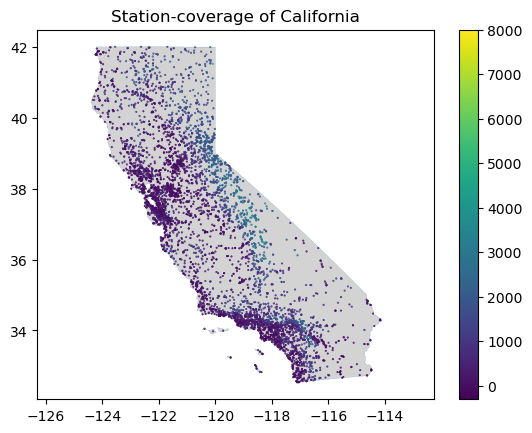

In [13]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title(f'Station-coverage of {target_state}')
plot_area_of_interest(ax, 'lightgray')
stations_metadata.plot('elevation', ax=ax, marker='.', markersize=1, colormap='viridis', legend=True)

In [14]:
satellite_client = SatelliteDataClient(ipaddress.ip_address(server_ip), 8010)
stations_to_sentinel_grid_cells_mapping: gpd.GeoDataFrame = satellite_client.queryContainingGeometry(
    stations_metadata[['name', 'geometry']])
sentinel_grid_cells: gpd.GeoDataFrame = stations_to_sentinel_grid_cells_mapping.drop_duplicates(subset=['cell_name']).copy()
print(f'Found {len(sentinel_grid_cells.index)} grid-cells')

Found 71 grid-cells


In [15]:
def plot_grid_cells(ax:plt.Axes):
    sentinel_grid_cells['geometry'].buffer(0).boundary.plot(ax=ax, edgecolor='black', alpha=0.5, linewidth=0.8, zorder=2)

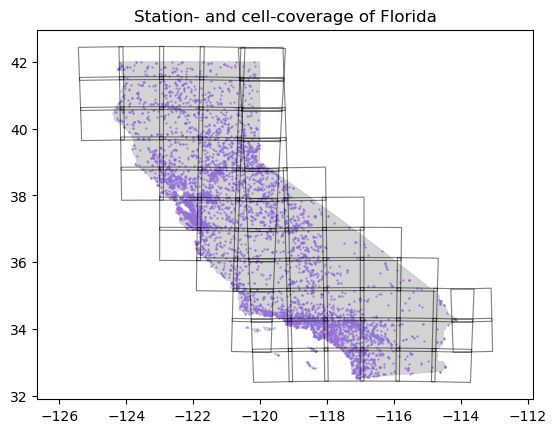

In [16]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Station- and cell-coverage of Florida')
plot_area_of_interest(ax, 'lightgray')
plot_stations(ax, 'mediumpurple')
plot_grid_cells(ax)

In [17]:
stations_per_grid_cell = stations_to_sentinel_grid_cells_mapping.groupby('cell_name')['name']
print(f'Average number of stations per grid cell: {stations_per_grid_cell.count().mean()}')

Average number of stations per grid cell: 103.04225352112677


In [60]:
sentinel_products_metadata_filepath = os.path.join(preprocessing_dir, 'sentinel_products_metadata.csv')
os.makedirs(os.path.dirname(sentinel_products_metadata_filepath), exist_ok=True)
if os.path.exists(sentinel_products_metadata_filepath):
    sentinel_products_metadata = pd.read_csv(sentinel_products_metadata_filepath, index_col=0)
else:
    sentinel_products_metadata_list = []
    for cell_name in sentinel_grid_cells['cell_name']:
        sentinel_products_metadata_list += [satellite_client.queryProductsMetadata(datetime_from, datetime_to, copernicus_login,
            cell_name=cell_name
        )]
        time.sleep(1)
    sentinel_products_metadata = pd.concat(sentinel_products_metadata_list)
    sentinel_products_metadata.drop_duplicates(inplace=True)
    sentinel_products_metadata.to_csv(sentinel_products_metadata_filepath)
sentinel_products_metadata['footprint'] = sentinel_products_metadata['footprint'].apply(lambda x: shapely.from_wkt(x))
sentinel_products_metadata['geometry'] = sentinel_products_metadata['footprint']
sentinel_products_metadata = gpd.GeoDataFrame(sentinel_products_metadata)
sentinel_products_metadata.set_crs(epsg=4326, inplace=True)
print(f'Found {len(sentinel_products_metadata.index)} entries')

Found 3569 entries


In [19]:
print(sentinel_products_metadata.columns)

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'datatakesensingstart', 'generationdate', 'beginposition',
       'endposition', 'ingestiondate', 'orbitnumber', 'relativeorbitnumber',
       'cloudcoverpercentage', 'sensoroperationalmode', 'gmlfootprint',
       'footprint', 'level1cpdiidentifier', 'tileid', 'hv_order_tileid',
       'format', 'processingbaseline', 'platformname', 'filename',
       'instrumentname', 'instrumentshortname', 'size', 's2datatakeid',
       'producttype', 'platformidentifier', 'orbitdirection',
       'platformserialidentifier', 'processinglevel', 'datastripidentifier',
       'granuleidentifier', 'identifier', 'uuid', 'geometry'],
      dtype='object')


In [20]:
date_columns = ['beginposition', 'endposition', 'generationdate', 'ingestiondate']
for col in date_columns:
    sentinel_products_metadata[col] = pd.to_datetime(sentinel_products_metadata[col], unit='ms', utc=True)

In [21]:
sentinel_products_metadata[date_columns]

,beginposition,endposition,generationdate,ingestiondate
41dce797-fa27-4c02-9869-0325207fb1ea,2023-01-27 19:06:49.024000+00:00,2023-01-27 19:06:49.024000+00:00,2023-01-27 20:57:59+00:00,2023-01-27 22:47:35.215000+00:00
48d807d2-6fa4-4fd5-9a77-0e19d3dd3327,2023-01-22 19:07:01.024000+00:00,2023-01-22 19:07:01.024000+00:00,2023-01-22 20:58:07+00:00,2023-01-22 23:12:29.560000+00:00
d58907a0-4f47-4f2a-bef1-59f4939cab48,2023-01-17 19:07:29.024000+00:00,2023-01-17 19:07:29.024000+00:00,2023-01-17 20:55:44+00:00,2023-01-17 22:12:52.132000+00:00
6f58d684-12ca-465a-a003-b768c673569f,2023-01-12 19:07:41.024000+00:00,2023-01-12 19:07:41.024000+00:00,2023-01-12 20:58:00+00:00,2023-01-12 23:01:49.382000+00:00
02c92d77-7724-41c9-b564-812c910e1a6e,2023-01-07 19:07:49.024000+00:00,2023-01-07 19:07:49.024000+00:00,2023-01-07 20:53:40+00:00,2023-01-07 22:21:25.163000+00:00
...,...,...,...,...
641b34b0-8798-496e-9824-206c45802535,2022-08-05 18:09:19.024000+00:00,2022-08-05 18:09:19.024000+00:00,2022-08-05 20:25:38+00:00,2022-08-05 23:04:24.597000+00:00
e34e7949-65b2-4094-849d-79572e454bc2,2022-08-03 18:19:31.024000+00:00,2022-08-03 18:19:31.024000+00:00,2022-08-03 22:08:12+00:00,2022-08-04 02:16:19.375000+00:00
b1afa757-6a5a-471a-a59f-8b6d5bea3c02,2022-08-03 18:19:31.024000+00:00,2022-08-03 18:19:31.024000+00:00,2022-08-03 22:08:12+00:00,2022-08-04 02:08:10.070000+00:00
2362a0b3-1b59-49c2-9425-7b27bdfd0da3,2022-10-12 18:23:11.024000+00:00,2022-10-12 18:23:11.024000+00:00,2022-10-12 21:43:44+00:00,2022-10-13 01:21:24.153000+00:00


In [22]:
sentinel_products_metadata_per_cell = sentinel_products_metadata.groupby(['tileid'])
sentinel_grid_cells['num_entries'] = sentinel_grid_cells['cell_name'].apply(
    lambda name: len(sentinel_products_metadata_per_cell.get_group(name))
)

<Axes: title={'center': 'Number of sentinel-products per cell'}>

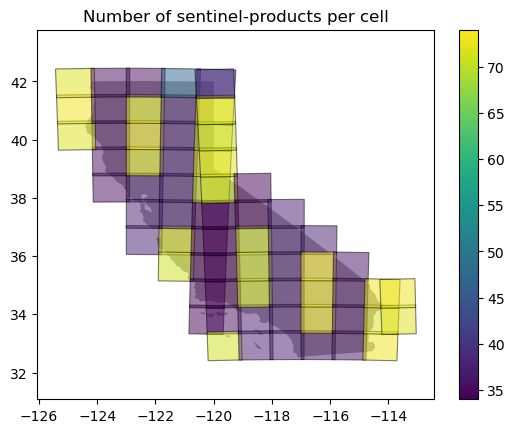

In [23]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Number of sentinel-products per cell')
plot_area_of_interest(ax, 'darkgray')
sentinel_grid_cells.plot('num_entries', ax=ax, markersize=0, edgecolor='black', facecolor='red',
    alpha=0.5, linewidth=0.8, legend=True, zorder=2)

In [24]:
products_sorted = sentinel_products_metadata.sort_values(by=['cloudcoverpercentage', 'beginposition'], ascending=[False, True])
products_range_selection = products_sorted[(products_sorted['cloudcoverpercentage'] < 30) | (products_sorted['cloudcoverpercentage'] > 70)].copy()
products_range_selection = products_sorted
print(f'After selection, {len(products_range_selection.index)} of {len(sentinel_products_metadata.index)} products remain')

After selection, 3569 of 3569 products remain


In [25]:
products_range_selection['geometry'] = products_range_selection['footprint']
remaining_grid_cells = products_range_selection.groupby(['tileid'])
print(f'After selection {len(remaining_grid_cells)} of {sentinel_grid_cells.shape[0]} grid cells remain')

After selection 71 of 71 grid cells remain


C:\Users\erikw\AppData\Local\Temp\ipykernel_24640\3631072304.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for label, data in remaining_grid_cells:


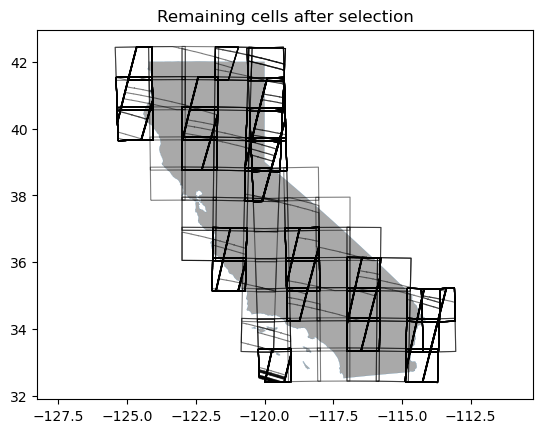

In [26]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Remaining cells after selection')
plot_area_of_interest(ax, 'darkgray')
for label, data in remaining_grid_cells:
    gpd.GeoDataFrame(data.drop_duplicates(subset=['geometry'])).plot(ax=ax, markersize=0, edgecolor='black', facecolor='none', alpha=0.5, linewidth=0.8, zorder=2)

In [27]:
def reproject_point(point:Point, crs_from, crs_to) -> Point:
    return Point(rasterio.warp.transform_geom(crs_from, crs_to, point)['coordinates'])

def reproject_polygon(polygon:Polygon, crs_from, crs_to) -> Polygon:
    intermediate = rasterio.warp.transform_geom(crs_from, crs_to, polygon)['coordinates']
    return Polygon(*intermediate)

In [28]:
def sphere_of_influence(point:Point, radius:float, crs) -> Polygon:
    crs_intermediate = CRS.from_epsg(32616)
    return reproject_polygon(reproject_point(point, crs, crs_intermediate).buffer(radius),
        crs_intermediate, crs)

In [29]:
products_range_selection['beginposition']

f749d2e7-0829-42b6-b9c7-76f4b5fb51e0   2022-09-17 19:10:41.024000+00:00
d64a2625-e0f2-4b60-b5eb-aa7c0074d456   2022-09-17 19:10:41.024000+00:00
bda23a38-0bb1-403e-8b37-292ad02b75d0   2022-12-03 18:17:29.024000+00:00
6c1791b1-07ba-4667-8576-38114de6e584   2022-12-03 18:17:29.024000+00:00
13aeddf0-be0e-4b85-9d0b-3808689f93d8   2022-12-22 18:48:09.024000+00:00
                                                     ...               
0e22703d-27ac-4202-a51a-fc064588d603   2023-01-28 18:36:29.024000+00:00
1303decc-78e1-439f-bc15-1bc814778d7e   2023-01-28 18:36:29.024000+00:00
ec63bd94-cac8-4957-ae5c-57ec7ebf38c4   2023-01-28 18:36:29.024000+00:00
9c5526a2-8e45-41c5-8300-134215b503e0   2023-01-28 18:36:29.024000+00:00
5bb0f533-5826-4147-8f24-47ff2326bd37   2023-01-31 18:46:19.024000+00:00
Name: beginposition, Length: 3569, dtype: datetime64[ns, UTC]

In [30]:
cloud_covers_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

In [31]:
cloud_cover_strength = {
    'CLR': 1,
    'SCT': 3,
    'BKN': 5,
    'OVC': 8
}

def get_max_cloud_cover(cloud_covers:List[DataSkyConditions]):
    cloud_covers_ranked = [(cloud_cover_strength[cc.cover],cc.cover) if cc.cover in cloud_cover_strength else (-1,cc.cover) for cc in cloud_covers]
    if any(cloud_covers_ranked):
        return max(cloud_covers_ranked)[1]
    else:
        return None

In [32]:
properties = [
    MetarProperty(MetarPropertyType.TEMPERATURE, UnitTemperature.CELSIUS),
    MetarProperty(MetarPropertyType.CURRENT_WEATHER),
    MetarProperty(MetarPropertyType.RECENT_WEATHER),
    MetarProperty(MetarPropertyType.SKY_CONDITIONS, UnitDistance.METERS),
    MetarProperty(MetarPropertyType.METAR_CODE)
]
properties_str = [str(prop) for prop in properties]

relevant_time_window = timedelta(hours=1)

filter_use_radius = True

all_metars_filepath = os.path.join(preprocessing_dir, 'all_metars.json')
recreate_data = False
if os.path.exists(all_metars_filepath):
    all_metars = pd.read_json(all_metars_filepath, orient='table')
    all_metars = MetarPandas.format_dataframe(all_metars, properties)
    if not set(properties_str).issubset(set(all_metars.columns)):
        # Columns are missing - recreate data
        recreate_data = True
else:
    recreate_data = True
if recreate_data:
    print('Recreating data..')
    all_metars_list = []
    for product_id, product in tqdm(products_range_selection.iterrows(), total=products_range_selection.shape[0]):
        # Query METAR data in relevant_time_range (R) like:
        # [obs_datetime - R/2, obs_datetime + R/2]
        half_time_range = relevant_time_window / 2.0
        product_datetime = product['beginposition']
        query_datetime_from = product_datetime - half_time_range
        query_datetime_to = product_datetime + half_time_range
        stations: gpd.GeoDataFrame = stations_metadata.loc[stations_per_grid_cell.get_group(product['tileid'])]
        product_footprint: shapely.MultiPolygon = product['footprint']
        if filter_use_radius:
            stations = stations[stations['geometry'].apply(
                lambda x: shapely.box(*sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).bounds)
                    .within(product_footprint)
            )]
        else:
            stations = stations[stations.within(product_footprint)]
        if not stations.empty:
            try:
                product_metars = ground_client.queryMetar(query_datetime_from, query_datetime_to, properties, stations['name'].to_list())
            except Exception:
                continue
            product_metars['product_id'] = product_id
            all_metars_list += [product_metars]
    all_metars = pd.concat(all_metars_list)
    all_metars.to_json(all_metars_filepath, orient='table', index=False)
still_all_metars = all_metars
all_metars = all_metars[
    all_metars[str(MetarProperty(MetarPropertyType.SKY_CONDITIONS, UnitDistance.METERS))].apply(lambda x: len(x) > 0)
]
all_metars = all_metars[all_metars['sky_conditions [M]'].apply(get_max_cloud_cover).isin(cloud_covers_order)]
metars_per_product = all_metars.groupby(['product_id'])

In [33]:
print(all_metars.shape[0])
print(still_all_metars.shape[0])

8008
8211


In [34]:
remaining_stations = all_metars['station'].drop_duplicates()
print(f'{remaining_stations.shape[0]} remaining stations')
remaining_grid_cells_metars:gpd.GeoDataFrame = stations_to_sentinel_grid_cells_mapping[stations_to_sentinel_grid_cells_mapping['name']
    .isin(remaining_stations)].drop_duplicates(subset=['cell_name'])[['geometry', 'cell_name']].copy()
missing_stations_metadata: gpd.GeoDataFrame = stations_metadata.loc[~stations_metadata.index.isin(remaining_stations)]
missing_stations_metadata = missing_stations_metadata.drop(columns=['index_right'])

125 remaining stations


c:\Users\erikw\anaconda3\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


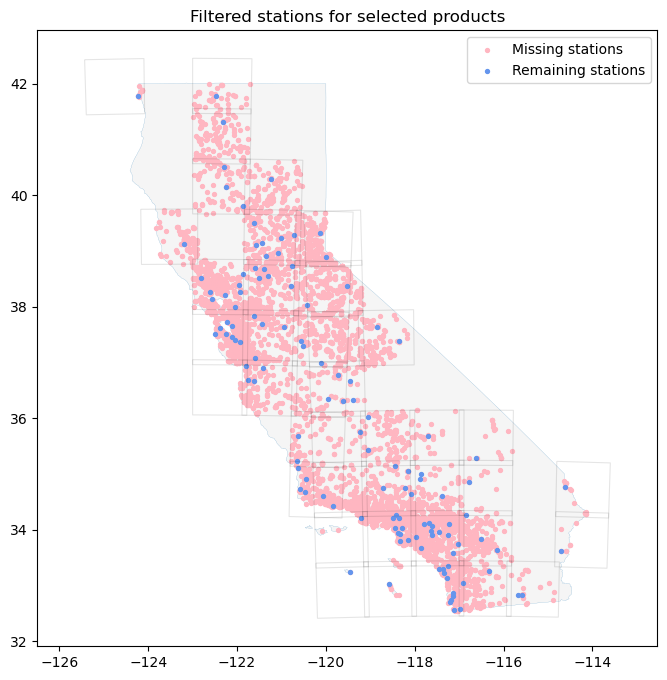

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal', 'datalim')
ax.set_title('Filtered stations for selected products')
plot_area_of_interest(ax, 'whitesmoke')
remaining_grid_cells_metars.plot(ax=ax, markersize=0, edgecolor='black', facecolor='none', alpha=0.1, linewidth=0.8, zorder=2)
missing_stations_metadata.sjoin(remaining_grid_cells_metars).plot(ax=ax, marker='o', color='lightpink', markersize=8, alpha=1, label='Missing stations')
stations_metadata.loc[remaining_stations].plot(ax=ax, marker='o', color='cornflowerblue', markersize=8, label='Remaining stations')
ax.legend()

In [36]:
products_filtered = sentinel_products_metadata.loc[metars_per_product.groups.keys()]
print('After filtering for the presence of cloud data in METARs and station containment in product footprint,\n'
      f'{len(products_filtered)} of {len(products_range_selection)} products remain '
      f'[{float(len(products_filtered)) / float(len(products_range_selection)) * 100.0:.1f} %]')

After filtering for the presence of cloud data in METARs and station containment in product footprint,
1813 of 3569 products remain [50.8 %]


In [37]:
products_filtered.index

Index(['00065e39-660f-4b17-a4ff-d528b87cef65',
       '002276a1-d3f5-494d-93c8-92e199d63501',
       '004524a1-be24-4363-82be-bc707f79fd2b',
       '0075f903-4865-49a0-8e18-d0f208f3ce2c',
       '007a0e41-5e1d-4529-94d3-784d3acc6c6e',
       '00bb9773-f695-4c6a-9238-96239be3c681',
       '00ce315c-6b73-4408-9fd3-4dc822774d92',
       '00f56041-00bc-416f-9dac-4f3e504fe081',
       '01187dcc-ed33-4d19-9858-16b57fad982d',
       '01774564-b74b-4e41-bc67-25e5d5a0be56',
       ...
       'fec9b071-777f-43f2-9775-b9e9e4353ce5',
       'fef1f2a3-b95c-4d93-9ab1-b1875e3e99be',
       'ff4c1688-498e-4d57-b6fc-8793705ae87b',
       'ff6a10c0-bafa-48d3-8d60-4f600f9cde16',
       'ff7b2786-370d-4270-a015-2b17deba4fbf',
       'ff8d7897-70db-4bac-a390-c20b40e61a7e',
       'ffa6a676-52c5-48b6-9c8f-f9cf2df60170',
       'ffb43da1-0854-4eaa-af6c-5347133fbd86',
       'ffcb7dba-8287-4d61-b3f8-268beba9901d',
       'ffef155f-3c61-4e07-a2c4-39a61331917d'],
      dtype='object', length=1813)

In [38]:
products_filtered[['beginposition', 'generationdate']].iloc[0]

beginposition    2023-01-06 18:47:51.024000+00:00
generationdate          2023-01-06 20:38:21+00:00
Name: 00065e39-660f-4b17-a4ff-d528b87cef65, dtype: datetime64[ns, UTC]

In [39]:
pd.set_option('display.max_colwidth', None)
metars_per_product.get_group(products_filtered.index[0])[['station', 'datetime', 'sky_conditions [M]', 'product_id']]

,station,datetime,sky_conditions [M],product_id
8054,BIH,2023-01-06 18:56:00,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",00065e39-660f-4b17-a4ff-d528b87cef65
8055,MMH,2023-01-06 18:37:00,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",00065e39-660f-4b17-a4ff-d528b87cef65
8056,MMH,2023-01-06 18:55:00,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",00065e39-660f-4b17-a4ff-d528b87cef65
8057,MMH,2023-01-06 19:14:00,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",00065e39-660f-4b17-a4ff-d528b87cef65


<Axes: >

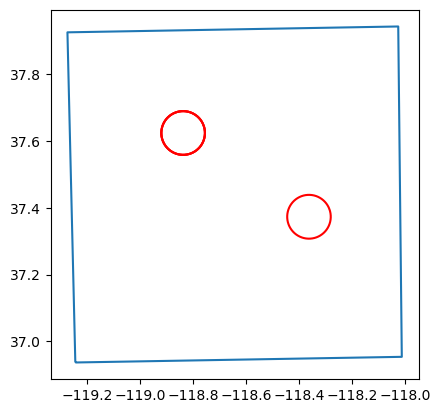

In [40]:
fig, ax = plt.subplots()
product_id_to_plot = products_filtered.index[0]
gpd.GeoDataFrame(pd.DataFrame(sentinel_products_metadata.loc[product_id_to_plot]).T).boundary.plot(ax=ax)
stations_metadata.loc[metars_per_product.get_group(product_id_to_plot)['station']]['geometry'].apply(
    lambda x: sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).boundary
).plot(ax=ax, color='red')

In [50]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']

os.makedirs(features_dir, exist_ok=True)
if 'state' not in products_filtered.columns:
    products_filtered['state'] = QueryStates.NEW
available_product_ids = [Path(file).stem for file in os.listdir(features_dir)]
products_filtered.loc[available_product_ids, 'state'] = QueryStates.AVAILABLE
products_to_download = products_filtered[~products_filtered['state'].isin(
    [QueryStates.AVAILABLE, QueryStates.INVALID, QueryStates.PROCESSED, QueryStates.UNAVAILABLE]
)]
num_products_ignore = products_filtered.shape[0] - products_to_download.shape[0]
for product_id in tqdm(products_to_download.index, initial=num_products_ignore, total= products_filtered.shape[0]):
    if any(filter(lambda path: path == product_id, available_product_ids)):
        # Skip existing files and directories
        continue
    if product_id not in metars_per_product.groups.keys():
        # If no data is available for a tile, skip it
        continue

    product_state = satellite_client.requestProduct(product_id, copernicus_login)
    products_filtered.at[product_id, 'state'] = product_state
    if product_state != QueryStates.AVAILABLE:
        continue

    stations: pd.Series = metars_per_product.get_group(product_id)['station']
    stations = stations.drop_duplicates()
    stations_with_geometry = stations_metadata[stations_metadata['name'].isin(stations)].copy()
    stations_with_geometry['name'] = stations_with_geometry.index
    stations_with_geometry = stations_with_geometry[['name', 'geometry']]
    stations_gdf = gpd.GeoDataFrame(stations_with_geometry)
    stations_gdf.set_crs(crs='EPSG:4326', inplace=True)
    satellite_client.extractFeatures(product_id, station_radius_of_influence, bands, stations_gdf, features_dir)
    time.sleep(1)

100%|██████████| 1813/1813 [00:01<00:00, 16.36it/s]


In [54]:
products_filtered.groupby(['state'])['state'].count()

state
QueryStates.AVAILABLE      1590
QueryStates.NEW               1
QueryStates.PENDING          17
QueryStates.PROCESSED         3
QueryStates.UNAVAILABLE     202
Name: state, dtype: int64

In [55]:
available_products = products_filtered[products_filtered['state'] == QueryStates.AVAILABLE]
print(f'{available_products.shape[0]} of {products_filtered.shape[0]} products are available [\
{float(available_products.shape[0]) / float(products_filtered.shape[0]) * 100.0:.1f} %]')

1590 of 1813 products are available [87.7 %]


In [56]:
available_products['beginposition']

00065e39-660f-4b17-a4ff-d528b87cef65   2023-01-06 18:47:51.024000+00:00
002276a1-d3f5-494d-93c8-92e199d63501   2022-12-05 18:57:49.024000+00:00
004524a1-be24-4363-82be-bc707f79fd2b   2022-09-10 18:29:29.024000+00:00
0075f903-4865-49a0-8e18-d0f208f3ce2c   2022-12-09 18:37:49.024000+00:00
007a0e41-5e1d-4529-94d3-784d3acc6c6e   2022-08-09 18:39:31.024000+00:00
                                                     ...               
ff6a10c0-bafa-48d3-8d60-4f600f9cde16   2022-12-29 18:37:59.024000+00:00
ff7b2786-370d-4270-a015-2b17deba4fbf   2023-01-28 18:36:29.024000+00:00
ffa6a676-52c5-48b6-9c8f-f9cf2df60170   2022-10-30 18:35:09.024000+00:00
ffcb7dba-8287-4d61-b3f8-268beba9901d   2022-12-15 18:58:09.024000+00:00
ffef155f-3c61-4e07-a2c4-39a61331917d   2022-12-22 18:48:09.024000+00:00
Name: beginposition, Length: 1590, dtype: datetime64[ns, UTC]